# Alzheimer's Classification [Train]

## Config

In [72]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from PIL import Image
from numpy import asarray
import gc
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import pandas as pd
import random
import time
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import StandardScaler
import torchmetrics
import cv2
import pickle
import transformers
import scipy.io.wavfile as wavfile
import datasets as ds
import librosa
import evaluate
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from librosa import effects


from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


In [73]:
class config:
    DEVICE = 'cuda'
    AMP = True
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = True

    MODEL = "facebook/hubert-base-ls960"
    BATCH_SIZE_TRAIN = 4
    BATCH_SIZE_VALID = 4
    EPOCHS = 20
    FOLDS = 5
    VAL_SIZE = .2   # If FOLDS=1 
    WEIGHT_DECAY = 0.0001
    MAX_LR = 1e-5
    
    
class paths:
    OUTPUT_DIR = './output/'
    DATASET = '../datasets/addresso/train/'
    TRANSCRIPT = '../datasets/addresso/train/transcription/'
    AUDIO = '../datasets/addresso/train/concatenated/'

### Utility functions

In [74]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    
LOGGER = get_logger()
seed_everything(config.SEED)

## Loading Data

In [75]:
df = pd.read_csv(paths.DATASET + 'meta_data.csv')
df = df.drop(columns=['age', 'gender', 'mmse'])
df['audio'] = df['ID'].apply(lambda x: paths.AUDIO +str(x)+'.wav')


In [76]:
if config.FOLDS > 1:
    gkf = GroupKFold(n_splits=config.FOLDS)
    for fold, (train_index, valid_index) in enumerate(gkf.split(df, df['class'], df['ID'])):
        df.loc[valid_index, "fold"] = int(fold)

df.head()
print(df.groupby(['fold', 'class']).count())

            ID  audio
fold class           
0.0  0      10     10
     1      12     12
1.0  0      11     11
     1      11     11
2.0  0      12     12
     1      10     10
3.0  0      11     11
     1      10     10
4.0  0      10     10
     1      11     11


In [77]:
class AudioDataset(Dataset):
    def __init__(self, df, mode='train', target_sr=16000):
        self.df = df
        self.mode = mode
        self.f_ex = transformers.AutoFeatureExtractor.from_pretrained(config.MODEL, do_normalize=True, return_attention_mask=True)
        self.target_sr = target_sr

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio']
        audio, sr = librosa.load(audio_path)

        if self.mode == 'train' and False:
          audio = self.speech_augmentation(audio, sr)

        audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=self.target_sr)
      
        features = self.preprocess(audio_resampled, max_length=45)
        labels = self.df.iloc[idx]['class']

        return features, labels

    def preprocess(self, audio, max_length):
        inputs = self.f_ex(audio, sampling_rate=self.target_sr, max_length=int(max_length*self.target_sr), return_tensors="pt", truncation=True, padding='max_length')
        return inputs["input_values"].squeeze(0)

    def speech_augmentation(self, audio, sr):
      # Define probabilities for each augmentation
      pitch_prob = 0.4  # 40% chance of pitch shifting
      volume_prob = 0.5  # 50% chance of volume perturbation

      if random.random() < pitch_prob:
        audio = self.pitch_shift(audio, sr)
      if random.random() < volume_prob:
        audio = self.volume_perturb(audio)
      return audio


    def pitch_shift(self, audio, sr, semitones=random.uniform(-2, 2)):
      return effects.pitch_shift(audio, sr=sr, n_steps=semitones)

    def volume_perturb(self, audio, gain_dB=random.uniform(-3, 3)):
      return effects.preemphasis(audio, coef=gain_dB)


In [78]:
class AlzheimersModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = transformers.AutoModelForAudioClassification.from_pretrained(config.MODEL, num_labels=2)
        
    def forward(self, x):
        out = self.model(x).logits
        return out

In [79]:
def train_epoch(train_loader, model, optimizer, epoch, scheduler):
    model.train()
    losses = AverageMeter()
    loss_fn = nn.CrossEntropyLoss()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for idx, (features, labels) in enumerate(tepoch):
            features = np.array(features)
            features = torch.from_numpy(features).to(device)
            labels = labels.to(device)
            batch_size = features.size(0)

            optimizer.zero_grad()
            
            outputs = model(features)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()
            losses.update(loss.item(), batch_size)

    print(f'Train loss: {losses.avg:.4f}')
    return losses.avg


def evaluate(model, valid_loader):
    model.eval()
    losses = AverageMeter()
    acc = AverageMeter()
    loss_fn = nn.CrossEntropyLoss()
    auc = torchmetrics.AUROC(task="binary")  # Create the AUC metric


    with torch.no_grad():
        all_probs = torch.tensor([]).to(device)
        all_labels = torch.tensor([]).to(device)
        for idx, (features, labels) in enumerate(valid_loader):
            features = np.array(features)
            features = torch.from_numpy(features).to(device)            
            labels = labels.to(device)
            batch_size = features.size(0)

            outputs = model(features)
            pred = torch.argmax(outputs, 1)
            loss = loss_fn(outputs, labels)
            losses.update(loss.item(), batch_size)

            # Get probabilities for the positive class (Alzheimer's)
            probs = (torch.softmax(outputs, dim=1)[:, 1])
            all_probs = torch.cat((all_probs, probs), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)

            auc.update(probs, labels) 

            accuracy = torchmetrics.functional.accuracy(pred, labels, 'binary')
            acc.update(accuracy.item(), batch_size)

    roc_auc = auc.compute()
    print(f'Valid loss: {losses.avg:.4f} | Valid accuracy: {acc.avg:.4f} | AUC-ROC: {roc_auc:.4f}')
    return losses.avg, acc.avg, roc_auc, all_probs.cpu().numpy(), all_labels.cpu().numpy()

In [80]:
torch.cuda.empty_cache()
gc.collect()

all_probs = []
all_labels = []

for fold in range(config.FOLDS):
    gc.collect()
    torch.cuda.empty_cache()
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]

    train_dataset = AudioDataset(train_df, mode='train')
    valid_dataset = AudioDataset(valid_df, mode='test')

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE_TRAIN, shuffle=True, num_workers=config.NUM_WORKERS)
    valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE_VALID, shuffle=False, num_workers=config.NUM_WORKERS)

    model = AlzheimersModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.MAX_LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(optimizer, 
                           max_lr=config.MAX_LR, 
                           epochs=config.EPOCHS, 
                           steps_per_epoch=len(train_loader), 
                           pct_start=0.1,
                           anneal_strategy='cos',
                           div_factor=10,
                           final_div_factor=100
                           )

    train_losses = []
    valid_losses = []
    accs = []
    aucs = []

    for epoch in range(config.EPOCHS):
        print(f'Epoch {epoch}')
        train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler)

        valid_loss, acc, auc, pr, al = evaluate(model, valid_loader)
        print(f'Accuracy: {acc:.4f}')

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accs.append(acc)
        aucs.append(auc)

    all_probs.append(pr)
    all_labels.append(al)
    torch.save(model.state_dict(), f'{paths.OUTPUT_DIR}model_{fold}.pth')
    del model, optimizer, scheduler
    gc.collect()
    torch.cuda.empty_cache()
    

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.6938
Valid loss: 0.6910 | Valid accuracy: 0.5909 | AUC-ROC: 0.5000
Accuracy: 0.5909
Epoch 1


100%|██████████| 22/22 [00:19<00:00,  1.11batch/s]


Train loss: 0.6903
Valid loss: 0.6870 | Valid accuracy: 0.5455 | AUC-ROC: 0.5667
Accuracy: 0.5455
Epoch 2


100%|██████████| 22/22 [00:19<00:00,  1.11batch/s]


Train loss: 0.6896
Valid loss: 0.6853 | Valid accuracy: 0.5909 | AUC-ROC: 0.5500
Accuracy: 0.5909
Epoch 3


100%|██████████| 22/22 [00:20<00:00,  1.10batch/s]


Train loss: 0.6894
Valid loss: 0.6852 | Valid accuracy: 0.5000 | AUC-ROC: 0.5750
Accuracy: 0.5000
Epoch 4


100%|██████████| 22/22 [00:20<00:00,  1.06batch/s]


Train loss: 0.6788
Valid loss: 0.6838 | Valid accuracy: 0.6364 | AUC-ROC: 0.6250
Accuracy: 0.6364
Epoch 5


100%|██████████| 22/22 [00:20<00:00,  1.06batch/s]


Train loss: 0.6669
Valid loss: 0.6700 | Valid accuracy: 0.5909 | AUC-ROC: 0.6500
Accuracy: 0.5909
Epoch 6


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.6584
Valid loss: 0.6647 | Valid accuracy: 0.6818 | AUC-ROC: 0.6500
Accuracy: 0.6818
Epoch 7


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.6312
Valid loss: 0.6806 | Valid accuracy: 0.5909 | AUC-ROC: 0.6500
Accuracy: 0.5909
Epoch 8


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.5978
Valid loss: 0.5919 | Valid accuracy: 0.7273 | AUC-ROC: 0.7250
Accuracy: 0.7273
Epoch 9


100%|██████████| 22/22 [00:20<00:00,  1.07batch/s]


Train loss: 0.5583
Valid loss: 0.6209 | Valid accuracy: 0.6364 | AUC-ROC: 0.6917
Accuracy: 0.6364
Epoch 10


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.5374
Valid loss: 0.5983 | Valid accuracy: 0.7727 | AUC-ROC: 0.7333
Accuracy: 0.7727
Epoch 11


100%|██████████| 22/22 [00:20<00:00,  1.07batch/s]


Train loss: 0.5095
Valid loss: 0.5723 | Valid accuracy: 0.7727 | AUC-ROC: 0.7833
Accuracy: 0.7727
Epoch 12


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.4086
Valid loss: 0.5768 | Valid accuracy: 0.6818 | AUC-ROC: 0.7667
Accuracy: 0.6818
Epoch 13


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.3270
Valid loss: 0.6078 | Valid accuracy: 0.6818 | AUC-ROC: 0.8167
Accuracy: 0.6818
Epoch 14


100%|██████████| 22/22 [00:19<00:00,  1.11batch/s]


Train loss: 0.3469
Valid loss: 0.6600 | Valid accuracy: 0.6364 | AUC-ROC: 0.7750
Accuracy: 0.6364
Epoch 15


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.3499
Valid loss: 0.5391 | Valid accuracy: 0.7727 | AUC-ROC: 0.8417
Accuracy: 0.7727
Epoch 16


100%|██████████| 22/22 [00:20<00:00,  1.10batch/s]


Train loss: 0.2932
Valid loss: 0.6010 | Valid accuracy: 0.6364 | AUC-ROC: 0.8167
Accuracy: 0.6364
Epoch 17


100%|██████████| 22/22 [00:20<00:00,  1.06batch/s]


Train loss: 0.2292
Valid loss: 0.6185 | Valid accuracy: 0.6818 | AUC-ROC: 0.8083
Accuracy: 0.6818
Epoch 18


100%|██████████| 22/22 [00:20<00:00,  1.06batch/s]


Train loss: 0.2620
Valid loss: 0.6042 | Valid accuracy: 0.6818 | AUC-ROC: 0.8333
Accuracy: 0.6818
Epoch 19


100%|██████████| 22/22 [00:20<00:00,  1.10batch/s]


Train loss: 0.2835
Valid loss: 0.5981 | Valid accuracy: 0.6818 | AUC-ROC: 0.8333
Accuracy: 0.6818


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.6934
Valid loss: 0.6914 | Valid accuracy: 0.5000 | AUC-ROC: 0.7025
Accuracy: 0.5000
Epoch 1


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.6890
Valid loss: 0.6929 | Valid accuracy: 0.5909 | AUC-ROC: 0.6198
Accuracy: 0.5909
Epoch 2


100%|██████████| 22/22 [00:20<00:00,  1.07batch/s]


Train loss: 0.6868
Valid loss: 0.6920 | Valid accuracy: 0.5000 | AUC-ROC: 0.5620
Accuracy: 0.5000
Epoch 3


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.6810
Valid loss: 0.6859 | Valid accuracy: 0.5000 | AUC-ROC: 0.6529
Accuracy: 0.5000
Epoch 4


100%|██████████| 22/22 [00:19<00:00,  1.11batch/s]


Train loss: 0.6746
Valid loss: 0.7068 | Valid accuracy: 0.5000 | AUC-ROC: 0.5537
Accuracy: 0.5000
Epoch 5


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.6460
Valid loss: 0.7149 | Valid accuracy: 0.5000 | AUC-ROC: 0.4215
Accuracy: 0.5000
Epoch 6


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.6240
Valid loss: 0.7117 | Valid accuracy: 0.5000 | AUC-ROC: 0.4711
Accuracy: 0.5000
Epoch 7


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.5601
Valid loss: 0.7558 | Valid accuracy: 0.5000 | AUC-ROC: 0.4793
Accuracy: 0.5000
Epoch 8


100%|██████████| 22/22 [00:20<00:00,  1.07batch/s]


Train loss: 0.5260
Valid loss: 0.7176 | Valid accuracy: 0.5909 | AUC-ROC: 0.6116
Accuracy: 0.5909
Epoch 9


100%|██████████| 22/22 [00:20<00:00,  1.05batch/s]


Train loss: 0.5116
Valid loss: 0.8404 | Valid accuracy: 0.5455 | AUC-ROC: 0.5372
Accuracy: 0.5455
Epoch 10


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.4928
Valid loss: 0.7404 | Valid accuracy: 0.6364 | AUC-ROC: 0.5868
Accuracy: 0.6364
Epoch 11


100%|██████████| 22/22 [00:20<00:00,  1.07batch/s]


Train loss: 0.3798
Valid loss: 0.7031 | Valid accuracy: 0.7273 | AUC-ROC: 0.6529
Accuracy: 0.7273
Epoch 12


100%|██████████| 22/22 [00:19<00:00,  1.10batch/s]


Train loss: 0.4018
Valid loss: 0.7644 | Valid accuracy: 0.6364 | AUC-ROC: 0.6198
Accuracy: 0.6364
Epoch 13


100%|██████████| 22/22 [00:19<00:00,  1.10batch/s]


Train loss: 0.3755
Valid loss: 0.7169 | Valid accuracy: 0.6364 | AUC-ROC: 0.6860
Accuracy: 0.6364
Epoch 14


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.2572
Valid loss: 0.7161 | Valid accuracy: 0.6364 | AUC-ROC: 0.6942
Accuracy: 0.6364
Epoch 15


100%|██████████| 22/22 [00:20<00:00,  1.08batch/s]


Train loss: 0.2856
Valid loss: 0.7948 | Valid accuracy: 0.6364 | AUC-ROC: 0.6942
Accuracy: 0.6364
Epoch 16


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.2605
Valid loss: 0.7970 | Valid accuracy: 0.6364 | AUC-ROC: 0.7025
Accuracy: 0.6364
Epoch 17


100%|██████████| 22/22 [00:20<00:00,  1.09batch/s]


Train loss: 0.2377
Valid loss: 0.7970 | Valid accuracy: 0.6364 | AUC-ROC: 0.6942
Accuracy: 0.6364
Epoch 18


100%|██████████| 22/22 [00:20<00:00,  1.10batch/s]


Train loss: 0.3199
Valid loss: 0.7991 | Valid accuracy: 0.6364 | AUC-ROC: 0.6860
Accuracy: 0.6364
Epoch 19


 36%|███▋      | 8/22 [00:07<00:13,  1.07batch/s]

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

# Save probabilities and labels for each fold in csv
all_probs_n = np.array(flatten(all_probs))
all_labels_n = np.array(flatten(all_labels))
res_df = pd.DataFrame({'probs': all_probs_n, 'labels': all_labels_n})
res_df.to_csv(f'{paths.OUTPUT_DIR}probs_labels.csv', index=False)

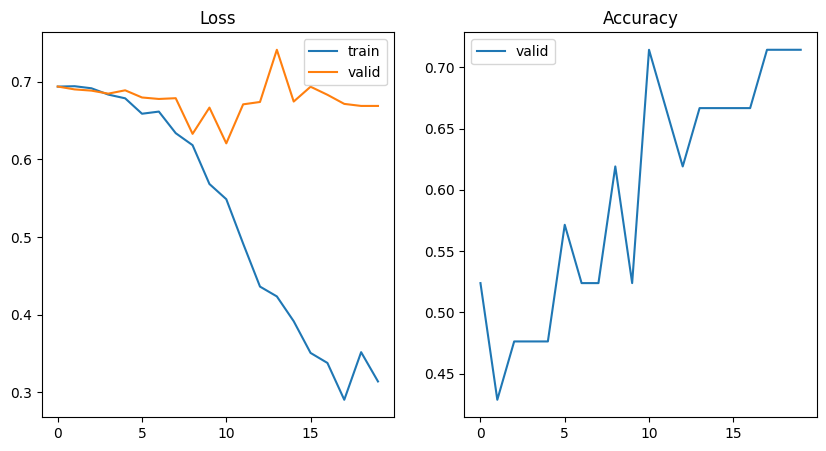

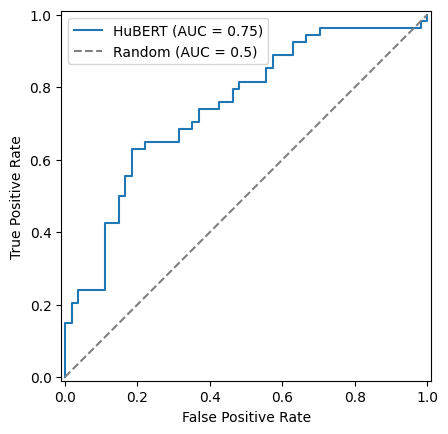

In [ ]:
# Plot training and validation loss and acc
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(accs, label='valid')
plt.legend()
plt.title('Accuracy')
plt.show()



fpr, tpr, thresholds = roc_curve(flatten(all_labels), flatten(all_probs))
auc_roc = roc_auc_score(flatten(all_labels), flatten(all_probs))

# fpr, tpr, thresholds = roc_curve(all_labels[0], all_probs[0])
# auc_roc = roc_auc_score(all_labels[0], all_probs[0])

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc, estimator_name='HuBERT')
display.plot()

# Add AUC = 0.5 line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.5)')

# Show the plot with legend
plt.legend()
plt.show()